In [ ]:
# Import libraries
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import pandas as pd
import io
import os, sys
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import numpy as np
import seaborn as sn
import logging
import math
import pickle
import statsmodels.api as sm
tf.get_logger().setLevel(logging.ERROR)

!pip install transformers

from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,roc_curve,roc_auc_score,accuracy_score,f1_score
from imblearn.over_sampling import RandomOverSampler

Mounted at /content/drive/


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 59.0 MB/s 
     |████████████████████████████████| 895 kB 60.2 MB/s 
     |████████████████████████████████| 77 kB 9.2 MB/s 
     |████████████████████████████████| 6.5 MB 49.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Check for GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## **Load Data**

In [2]:
data = pd.read_csv("~/w266_project_topmusichits/data/processed/songs_charts_final.csv")
print(data.columns)
print("Length of data",len(data))

Index(['song_year', 'song_name', 'artist_name', 'album_name', 'genre',
       'lyrics', 'danceability', 'loudness', 'speechiness', 'acousticness',
       'valence', 'tempo', 'num_nonlexvoc', 'star', 'hit'],
      dtype='object')
Length of data 8546


In [ ]:
# Visualize data
data[data.song_name=='Cool']
#data['genre'].value_counts()

,song_year,song_name,artist_name,album_name,genre,lyrics,danceability,loudness,speechiness,acousticness,valence,tempo,num_nonlexvoc,star,hit
7904,2019,Cool,Jonas Brothers,Happiness Begins,r&b,"I'm feeling so cool From top to the bottom, ju...",medium,medium,medium,low,high,low,high,yes,1


## Prepare Train, Validation, Test Datasets and Apply Lyric Chunking

In [ ]:
# Define cutoff date and split train and test sets
split_year = 2017
train_df = data[data['song_year'] < split_year]
test_df = data[data['song_year'] >= split_year]


# Define features and target
X = train_df.drop(['hit'], axis=1)  #keep only the columns that we will use as x's. Right now I am only removing the y from it but we need to remove all the useless columns
y = train_df['hit']

# Split training data into training and validation sets (70% - 30%)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42) #Random state is to get reproducible results


# Oversample hits in dataset to have a 3:2 balance of non-hits vs hits
oversample = RandomOverSampler(sampling_strategy=2/3)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)


# Recombine the features and target datasets
train_df_over = pd.concat([X_train_over.reset_index(drop=True), y_train_over.reset_index(drop=True)],axis=1)
val_df = pd.concat([X_val.reset_index(drop=True), y_val.reset_index(drop=True)],axis=1)

# print("After oversampling")
# print(y_train_over.value_counts())

In [ ]:
def split_lyrics(song,chunk_length=250):
    """
    Split out text into chunks with specified chunk length (default is 250 words) 
    and 50-word overlap and prepend metadata chunk (based on other column values) 
    to each lyric chunk, as well as [SEP] token to separate out metadata and lyric chunk

    Return: list of lyric chunks for song (metadata+[SEP]+lyric chunks)
    """

    # Create metadata string based on other columns
    metadata = ["genre "+song['genre']+" danceability "+song['danceability']\
                +" loudness "+song['loudness']+" speechiness "+song['speechiness']\
                +" acousticness "+song['acousticness']+" valence "+song['valence']\
                +" tempo "+song['tempo']+" num_nonlexvoc "+song['num_nonlexvoc']\
                +" star "+song['star']
                +" [SEP]"
                ]
    l_total = []
    l_partial = []

    # Check number of chunks that song needs to be divided up on
    if len(song['lyrics'].split())//(chunk_length-50) > 0:
        n = math.ceil(len(song['lyrics'].split())/(chunk_length-50))
    else: 
        n = 1
    
    # Create chunks with 50-word overlap
    for w in range(n):
        # If this is first chunk
        if w == 0:
            l_partial = song['lyrics'].split()[:chunk_length]
            l_total.append(" ".join(metadata+l_partial))

        # If not, create next chunk from 50 words before ending of previous chunk
        else:
            #print(w)
            l_partial = song['lyrics'].split()[w*(chunk_length-50):w*(chunk_length-50) + chunk_length]
            l_total.append(" ".join(metadata+l_partial))

    return l_total

In [ ]:
# Apply lyric chunking for training/val/test datasets - lyric_split column will contain a list of all the chunks (String format) for EACH song
train_df_over['lyric_split'] = train_df_over.apply(split_lyrics,axis=1)
val_df['lyric_split'] = val_df.apply(split_lyrics,axis=1)
test_df['lyric_split'] = test_df.apply(split_lyrics,axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# Get data for all chunks of lyrics for training/validation/test datasets (including all the labels)
train_data_chunks = [i for val in train_df_over['lyric_split'] for i in val]
train_labels = [val['hit'] for i,val in train_df_over.iterrows() for t in range(len(val['lyric_split']))]

val_data_chunks = [i for val in val_df['lyric_split'] for i in val]
val_labels = [val['hit'] for i,val in val_df.iterrows() for t in range(len(val['lyric_split']))]

test_data_chunks = [i for val in test_df['lyric_split'] for i in val]
test_labels = [val['hit'] for i,val in test_df.iterrows() for t in range(len(val['lyric_split']))]

# Verify data and labels lists are the same length for train/val/test
assert(len(train_data_chunks)==len(train_labels))
assert(len(val_data_chunks)==len(val_labels))
assert(len(test_data_chunks)==len(test_labels))

### OPTIONAL Analysis on distribution of number of songs per chunk amount

In [ ]:
# ANALYSIS: Understand number of songs with per lyric chunk distribution (i.e. how many songs have)

# Train set
max_len_train = 0
train_len_list = []
for val in train_df_over['lyric_split']:
     train_len_list.append(len(val))
     max_len_train = max(max_len_train,len(val))
print("Max number of lyric splits in training set:",max_len_train)

# Validation set
max_len_val = 0
val_len_list = []
for val in val_df['lyric_split']:
     val_len_list.append(len(val))
     max_len_val = max(max_len_val,len(val))
print("Max number of lyric splits in validation set:",max_len_val)

# Test set
max_len_test = 0
test_len_list = []
for val in test_df['lyric_split']:
     test_len_list.append(len(val))
     max_len_test = max(max_len_test,len(val))
print("Max number of lyric splits in test set:",max_len_test)
print("\n")

def lyric_chunk_freq(lst):
    d = {}
    for i in lst:
        if d.get(i):
            d[i] += 1
        else:
            d[i] = 1
    return d

print("Distribution of chunks in training list:")
#print(lyric_chunk_freq(train_len_list))
for key in sorted(lyric_chunk_freq(train_len_list)):
    print("%s: %s" % (key, lyric_chunk_freq(train_len_list)[key]))

print("\nDistribution of chunks in validation list:")
for key in sorted(lyric_chunk_freq(val_len_list)):
    print("%s: %s" % (key, lyric_chunk_freq(val_len_list)[key]))
#print(lyric_chunk_freq(val_len_list))

print("\nDistribution of chunks in test list:")
for key in sorted(lyric_chunk_freq(test_len_list)):
    print("%s: %s" % (key, lyric_chunk_freq(test_len_list)[key]))
#print(lyric_chunk_freq(test_len_list))

Max number of lyric splits in training set: 18
Max number of lyric splits in validation set: 17
Max number of lyric splits in test set: 37


Distribution of chunks in training list:
1: 249
2: 1394
3: 1094
4: 599
5: 461
6: 258
7: 112
8: 52
9: 65
10: 33
11: 40
12: 18
13: 11
14: 6
15: 11
16: 5
17: 2
18: 1

Distribution of chunks in validation list:
1: 96
2: 511
3: 361
4: 212
5: 153
6: 70
7: 21
8: 15
9: 6
10: 4
11: 10
12: 4
13: 1
14: 3
15: 2
16: 3
17: 3

Distribution of chunks in test list:
1: 166
2: 1116
3: 1125
4: 510
5: 261
6: 132
7: 81
8: 51
9: 40
10: 30
11: 24
12: 8
13: 18
14: 15
15: 8
16: 6
17: 9
18: 4
19: 4
20: 3
21: 5
22: 5
24: 1
25: 2
27: 1
29: 1
30: 1
31: 3
34: 1
37: 1


In [ ]:
# ANALYSIS: Check proportion of label values (0s and 1s) for all datasets
print("Proportion of values in train labels:",round(np.mean(train_labels),2)) # This is oversampled
print("Proportion of values in validation labels:",round(np.mean(val_labels),2))
print("Proportion of values in test labels:",round(np.mean(test_labels),2))

Proportion of values in train labels: 0.48
Proportion of values in validation labels: 0.42
Proportion of values in test labels: 0.27


## Load BERT tokenizer and Encode Train/Validation/Training Sets

In [ ]:
# Load BERT tokenizer 
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

# Set max length for each row of data
max_length = 512

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Tokenize train data
x_train = tokenizer(train_data_chunks, 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')


# Grab input IDs, token type IDs, and attention masks and convert those+labels to numpy arrays
X_train = np.array([x_train.input_ids,x_train.token_type_ids,x_train.attention_mask])
y_train = np.array(train_labels)


In [ ]:
# Tokenize validation data
x_val = tokenizer(val_data_chunks, 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')


# Grab input IDs, token type IDs, and attention masks and convert those+labels to numpy arrays
X_val = np.array([x_val.input_ids,x_val.token_type_ids,x_val.attention_mask])
y_val = np.array(val_labels)


In [ ]:
# Tokenize test data
x_test = tokenizer(test_data_chunks, 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')


# Grab input IDs, token type IDs, and attention masks and convert those+labels to numpy arrays
X_test = np.array([x_test.input_ids,x_test.token_type_ids,x_test.attention_mask])
y_test = np.array(test_labels)


### OPTIONAL: Save train/validation/test tensors and read later

In [ ]:
# Save training tensors
with open('drive/MyDrive/X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
    f.close()

with open('drive/MyDrive/y_train.pkl', 'wb') as g:
    pickle.dump(y_train, g)
    g.close()

# Save validation tensors
with open('drive/MyDrive/X_val.pkl', 'wb') as h:
    pickle.dump(X_val, h)
    h.close()

with open('drive/MyDrive/y_val.pkl', 'wb') as i:
    pickle.dump(y_val, i)
    i.close()

# Save test tensors
with open('drive/MyDrive/X_test.pkl', 'wb') as j:
    pickle.dump(X_test, j)
    j.close()

with open('drive/MyDrive/y_test.pkl', 'wb') as k:
    pickle.dump(y_test, k)    
    k.close()

In [ ]:
# Read saved training tensors
with open('drive/MyDrive/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
    f.close()

with open('drive/MyDrive/y_train.pkl', 'rb') as g:
    y_train = pickle.load(g)

# Read saved validation tensors
with open('drive/MyDrive/X_val.pkl', 'rb') as h:
    X_val = pickle.load(h)

with open('drive/MyDrive/y_val.pkl', 'rb') as i:
    y_val = pickle.load(i)

# Read saved test tensors
with open('drive/MyDrive/X_test.pkl', 'rb') as j:
    X_test = pickle.load(j)

with open('drive/MyDrive/y_test.pkl', 'rb') as k:
    y_test = pickle.load(k) 

## Load BERT model and train model

In [ ]:

def lyric_classification_model(hidden_size = 200, train_layers = -1, lr_rate=5e-5, dropout=0.1):
    """
    Build classification model with BERT to classify the lyric chunks for each song
    """
    np.random.seed(1337)

    # Instantiate optimizer
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate)

    # Load in pre-trained BERT Model
    bert_model = TFBertModel.from_pretrained(model_name) 

    # Convert into keras layers and put into dictionary
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask}


    # Restrict training to the train_layers outer transformer layers - 
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False

    # Put BERT inputs into pre-trained BERT model
    bert_out = bert_model.bert(bert_inputs)

    # Gather CLS tokens for each row
    classification_token = tf.keras.layers.Lambda(lambda x: x[:,0,:], name='get_first_vector')(bert_out[0])

    # Dense and Dropout Layers
    hidden = tf.keras.layers.Dense(hidden_size, name='hidden_layer')(classification_token)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], 
                                          outputs=[classification])
    
    classification_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics=['accuracy'])


    return classification_model

In [ ]:
# Build classification model
classification_model = lyric_classification_model(train_layers=3,lr_rate=5e-6,dropout=0.2)     


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
classification_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 512)]       0           []                               
 er)                                                                                              
                                                                                            

In [ ]:
# Fit classification model
classification_model.fit([X_train[0], X_train[1], X_train[2]], y_train,
                          validation_data=([X_val[0], X_val[1], X_val[2]],
                          y_val),
                          epochs=3,
                          batch_size=8)

Epoch 1/3
1560/1560 [==============================] - 618s 391ms/step - loss: 0.6396 - accuracy: 0.6372 - val_loss: 0.6251 - val_accuracy: 0.6572
Epoch 2/3
1560/1560 [==============================] - 609s 390ms/step - loss: 0.5639 - accuracy: 0.7069 - val_loss: 0.6568 - val_accuracy: 0.6502
Epoch 3/3
1560/1560 [==============================] - 606s 389ms/step - loss: 0.5000 - accuracy: 0.7510 - val_loss: 0.6277 - val_accuracy: 0.6907


In [ ]:
classification_model.save('drive/MyDrive/classification_models/model_FINAL_withoutFineTuning')
#classification_model_loaded = keras.models.load_model('drive/MyDrive/classification_models/model_FINAL_TUNED')

## Predict and Evaluate Results of Classification Model

In [ ]:
# Calculate predictions of song chunks
y_predicted_proba = classification_model.predict([X_test[0], X_test[1], X_test[2]])

# Get 1D array of the song chunk probabilities
y_predicted_proba = y_predicted_proba.flatten()

# Uncomment below lines  if you want to use a loaded model
# y_predicted_proba = classification_model_loaded.predict([X_test[0], X_test[1], X_test[2]])
# y_predicted_proba = np.concatenate(y_predicted_proba).ravel()

# Verify that total number of chunks is between predicted probabilities and test set
print("Test Predictions (Chunks) shape:",y_predicted_proba.shape)
print("Test Set (Chunks) shape:", y_test.shape)
assert(y_predicted_proba.shape==y_test.shape)

Test Predictions (Chunks) shape: (10541,)
Test Set (Chunks) shape: (10541,)


NOTE: Keep below two cells commented unless you want to save/load new chunk probabilities

In [ ]:
# Write chunk probabilties (y_predicted_proba) for chunks to text files
# with open("drive/MyDrive/y_final_probas_chunk_noFineTuning.txt","w") as f:
#     for item in y_predicted_proba:
#         f.write('%s\n' % item)

In [ ]:
# Load most recent chunk probabilities from text file into python list
# NOTE: Make sure text file is in drive/MyDrive before running this

# # define an empty list that you will read y_predictions into
# y_predicted_loaded = []
# with open('drive/MyDrive/y_final_probas_chunk_noFineTuning.txt', 'r') as filehandle:
#     for line in filehandle:
#         # remove linebreak which is the last character of the string
#         currentPlace = line[:-1]

#         # add item to the list
#         y_predicted_loaded.append(float(currentPlace))

# # Convert list to numpy array like original variable
# y_predicted_proba = np.array(y_predicted_loaded)



In [ ]:
# Compile song chunk probabilities per song into a dataframe

def song_to_chunk_probas(y_predicted_proba):
    """This function compiles song chunk probabilities per song
       and returns this into a dictionary with the format
       song_id_1: [chunk_proba1, chunk_proba2, ...]
       song_id_2: [chunk_proba1, chunk_proba2, ...] etc"""
    # Create dict of indexes of each test_df song & number of chunks for that song
    chunk_len_dict = {i: len(val['lyric_split']) for i,val in test_df.iterrows()}

    # Verify that total number of chunks = total number of predicted values
    assert(sum(chunk_len_dict.values())==len(y_predicted_proba))

    # Gather indexes of first and last songs from dictionary
    dict_counter = int(list(chunk_len_dict.keys())[0])
    last_dict_counter = int(list(chunk_len_dict.keys())[-1])

    # Call counters
    i=0
    song_count = 0

    # Instantiate new list that'll contain probabilities PER SONG
    new_pred_proba_dict = {}

    while dict_counter<=last_dict_counter:
        # Gather number of chunks for song based on value in dictionary
        num_chunks = chunk_len_dict[dict_counter]

        # Gather probabilities of chunks for one song
        song_chunk_proba = y_predicted_proba[i:i+num_chunks]

        # Add to song counter
        song_count+=1

        # Add list of song chunk probabilities to dict
        #new_pred_proba_list.append(np.mean(song_chunk_proba))
        new_pred_proba_dict[dict_counter] = song_chunk_proba

        # Move to next key in dictionary
        dict_counter+=1

        # Move to next song index in predicted probabilities list
        i+=num_chunks
    
    # Calculate max number of chunks and create column names based on this value
    max_chunks = max([len(item) for key,item in new_pred_proba_dict.items()])
    columns = ["chunk"+str(i) for i in range(max_chunks)]

    # Convert dictionary --> dataframe that contains probabilities of chunks for each song
    chunk_proba_df = pd.DataFrame.from_dict(new_pred_proba_dict,orient='index')

    # Fill any null values with 0
    chunk_proba_df = chunk_proba_df.fillna(0)

    # Rename columns
    chunk_proba_df.columns = columns

    # Set index
    chunk_proba_df.index.names = ['ID']

    return(chunk_proba_df)


In [ ]:
# Dataframe containing song chunk probabilities per song ID
chunk_proba_df = song_to_chunk_probas(y_predicted_proba)
chunk_proba_df.head()

,chunk0,chunk1,chunk2,chunk3,chunk4,chunk5,chunk6,chunk7,chunk8,chunk9,...,chunk18,chunk19,chunk20,chunk21,chunk22,chunk23,chunk24,chunk25,chunk26,chunk27
ID,,,,,,,,,,,,,,,,,,,,,
4914,0.111307,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4915,0.673436,0.751855,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4916,0.122426,0.049455,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4917,0.081810,0.104287,0.142374,0.044733,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4918,0.232888,0.287691,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Run Regression to calculate accuracy and f1-score

In [ ]:
# Fit regression over song probabilities per chunk
mod = sm.OLS(test_df['hit'],chunk_proba_df)
fii = mod.fit()

fii.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    hit   R-squared (uncentered):                   0.310
Model:                            OLS   Adj. R-squared (uncentered):              0.305
Method:                 Least Squares   F-statistic:                              62.22
Date:                Sun, 10 Apr 2022   Prob (F-statistic):                   1.28e-266
Time:                        04:47:15   Log-Likelihood:                         -831.71
No. Observations:                3632   AIC:                                      1715.
Df Residuals:                    3606   BIC:                                      1877.
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
chunk0         0.1036      0.022      4.609      0.000       0.060       0.148
chunk1         0.0328      0.027      1.228      0.219      -0.020       0.085
chunk2         0.1355      0.022      6.058      0.000       0.092       0.179
chunk3         0.0541      0.031      1.729      0.084      -0.007       0.115
chunk4         0.0643      0.045      1.441      0.150      -0.023       0.152
chunk5         0.1370      0.062      2.208      0.027       0.015       0.259
chunk6         0.1159      0.082      1.409      0.159      -0.045       0.277
chunk7         0.0211      0.091      0.233      0.815      -0.157       0.199
chunk8        -0.0377      0.116     -0.324      0.746      -0.266       0.191
chunk9         0.2373      0.129      1.835      0.067      -0.016       0.491
chunk10       -0.2164      0.132     -1.637      0.102      -0.476       0.043
chunk11       -0.0830      0.164     -0.507      0.612      -0.404       0.238
chunk12        0.6384      0.210      3.040      0.002       0.227       1.050
chunk13       -0.2461      0.202     -1.218      0.223      -0.642       0.150
chunk14        0.2120      0.238      0.889      0.374      -0.255       0.679
chunk15       -0.4196      0.254     -1.654      0.098      -0.917       0.078
chunk16       -0.4296      0.341     -1.261      0.207      -1.098       0.238
chunk17        0.6997      0.429      1.630      0.103      -0.142       1.541
chunk18        0.0801      1.014      0.079      0.937      -1.909       2.069
chunk19       -0.2972      1.741     -0.171      0.864      -3.711       3.117
chunk20       -0.1764      1.948     -0.091      0.928      -3.996       3.643
chunk21        0.3989      0.705      0.566      0.572      -0.983       1.781
chunk22        0.2919      0.473      0.617      0.537      -0.636       1.220
chunk23       -0.4079      0.547     -0.746      0.456      -1.480       0.664
chunk24       -0.6431      0.255     -2.523      0.012      -1.143      -0.143
chunk25       -0.4017      0.213     -1.882      0.060      -0.820       0.017
chunk26        0.9556      0.315      3.038      0.002       0.339       1.572
chunk27        1.3058      0.430      3.038      0.002       0.463       2.149
==============================================================================
Omnibus:                     1216.313   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3289.079
Skew:                           1.814   Prob(JB):                         0.00
Kurtosis:                       5.929   Cond. No.                     1.43e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance mat

In [ ]:
# Calculate aggregated probability for song based on regression coefficients
# NOTE: Check summary above to make sure you are getting right number of chunks

chunk_proba_df['agg_prob'] = fii.params[0]*chunk_proba_df['chunk0'] + fii.params[1]*chunk_proba_df['chunk1'] + \
                             fii.params[2]*chunk_proba_df['chunk2'] + fii.params[3]*chunk_proba_df['chunk3'] + \
                             fii.params[4]*chunk_proba_df['chunk4'] + fii.params[5]*chunk_proba_df['chunk5'] + \
                             fii.params[6]*chunk_proba_df['chunk6'] + fii.params[7]*chunk_proba_df['chunk7'] + \
                             fii.params[8]*chunk_proba_df['chunk8'] + fii.params[9]*chunk_proba_df['chunk9'] + \
                             fii.params[10]*chunk_proba_df['chunk10'] + fii.params[11]*chunk_proba_df['chunk11'] + \
                             fii.params[12]*chunk_proba_df['chunk12'] + fii.params[13]*chunk_proba_df['chunk13'] + \
                             fii.params[14]*chunk_proba_df['chunk14'] + fii.params[15]*chunk_proba_df['chunk15'] + \
                             fii.params[16]*chunk_proba_df['chunk16'] + fii.params[17]*chunk_proba_df['chunk17'] + \
                             fii.params[18]*chunk_proba_df['chunk18'] + fii.params[19]*chunk_proba_df['chunk19'] + \
                             fii.params[20]*chunk_proba_df['chunk20'] + fii.params[21]*chunk_proba_df['chunk21'] + \
                             fii.params[22]*chunk_proba_df['chunk22'] + fii.params[23]*chunk_proba_df['chunk23'] + \
                             fii.params[24]*chunk_proba_df['chunk24'] + fii.params[25]*chunk_proba_df['chunk25'] + \
                             fii.params[26]*chunk_proba_df['chunk26'] + fii.params[27]*chunk_proba_df['chunk27'] 


NOTE: Keep below two cells commented unless you want to save/load new song probabilities

In [ ]:
# Write song probabilties (chunk_proba_df['agg_prob']) for chunks to text files
# with open("drive/MyDrive/y_final_probas_song.txt","wb") as f:
#     for item in chunk_proba_df['agg_prob']:
#         f.write('%s\n' % item)

In [ ]:
# Load most recent song probabilities from text file into python list
# NOTE: Make sure text file is in drive/MyDrive before running this

# # define an empty list that you will read y_predictions into
# y_predicted_loaded = []
# with open('drive/MyDrive/y_final_probas_chunk_noFineTuning.txt', 'r') as filehandle:
#     for line in filehandle:
#         # remove linebreak which is the last character of the string
#         currentPlace = line[:-1]

#         # add item to the list
#         y_predicted_loaded.append(float(currentPlace))

# # Load song probability list into original variable
# chunk_probs = y_predicted_loaded



In [ ]:
def predictions_accuracy_precision(chunk_probs):
    """This function takes in all of the song chunk probabilities and 
       displays the accuracy and precision for different cutoffs values 
       in order for the user to determine the best cutoff value that 
       maximizes both accuracy and precision"""

    cutoff = 0.9

    # Search cutoff values from 0.1 to 0.9
    while cutoff>0.1:
        y_predicted_songs_new = np.where(chunk_probs>cutoff,1,0)
        accuracy = round(accuracy_score(test_df['hit'], y_predicted_songs_new),4)
        f1score = round(f1_score(test_df['hit'], y_predicted_songs_new),4)
        print("For cutoff value %.1f, accuracy is %.3f, f1 score is %.3f"
                %(cutoff,accuracy,f1score))
        cutoff-=0.1




In [ ]:
# Call above function to calculate different accuracies and f1-scores per cutoff value
predictions_accuracy_precision(chunk_proba_df['agg_prob'])

# Uncomment below if reading song probabilities from text file
#predictions_accuracy_precision(chunk_probs)

For cutoff value 0.9, accuracy is 0.871, f1 score is 0.075
For cutoff value 0.8, accuracy is 0.874, f1 score is 0.119
For cutoff value 0.7, accuracy is 0.875, f1 score is 0.150
For cutoff value 0.6, accuracy is 0.876, f1 score is 0.202
For cutoff value 0.5, accuracy is 0.880, f1 score is 0.299
For cutoff value 0.4, accuracy is 0.879, f1 score is 0.357
For cutoff value 0.3, accuracy is 0.866, f1 score is 0.425
For cutoff value 0.2, accuracy is 0.797, f1 score is 0.450
For cutoff value 0.1, accuracy is 0.620, f1 score is 0.382


In [ ]:
# Calculate predicted labels based on cutoff value that you choose
cutoff = 0.4
y_predicted_songs = np.where(chunk_proba_df['agg_prob']>cutoff,1,0)

## Analysis Of Results

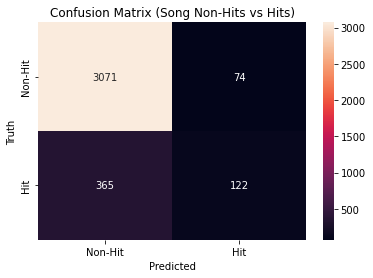

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(test_df['hit'],y_predicted_songs)
ax = sn.heatmap(cm,annot=True,fmt='d')

ax.set_title("Confusion Matrix (Song Non-Hits vs Hits)")
ax.set_xlabel("Predicted")
ax.set_ylabel('Truth')

# Set tick labels
ax.xaxis.set_ticklabels(['Non-Hit','Hit'])
ax.yaxis.set_ticklabels(['Non-Hit','Hit'])

# Show confusion matrix
plt.show()

In [ ]:
# Get AUC and accuracy scores at song level
auc_score=roc_auc_score(test_df['hit'],y_predicted_songs)
accuracy = accuracy_score(test_df['hit'], y_predicted_songs)
print("AUC Score (Songs):",round(auc_score,3))
print("Accuracy Score (Songs):",round(accuracy,3))


AUC Score (Songs): 0.613
Accuracy Score (Songs): 0.879


In [28]:
test_df['preds'] = y_predicted_songs
test_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,song_year,song_name,artist_name,album_name,genre,lyrics,danceability,loudness,speechiness,acousticness,valence,tempo,num_nonlexvoc,star,hit,lyric_split,preds
4914,2017,Shukar,Andra,Shukar,r&b,House on fire windows broke Cricle dancing clo...,medium,medium,medium,high,high,low,low,no,0,[genre r&b danceability medium loudness medium...,0
4915,2017,Song #3,Stone Sour,Song #3,rock,"If you take a step towards me, you will take m...",low,medium,medium,low,medium,high,low,yes,0,[genre rock danceability low loudness medium s...,0
4916,2017,Run to the Money,D'african,The Heartbreak Cure,rap,I run to the money I run to it I run I run Run...,medium,medium,low,low,low,high,low,no,0,[genre rap danceability medium loudness medium...,0
4917,2017,PURPLE TUESDAY (feat. Joey Bada$$ & Jesse Boyk...,Rejjie Snow,PURPLE TUESDAY (feat. Joey Bada$$ & Jesse Boyk...,r&b,"Seven years old, I asked Christ and the genie ...",medium,medium,high,high,high,low,low,no,0,[genre r&b danceability medium loudness medium...,0
4918,2017,Now,Miguel,War & Leisure,r&b,CEO of the free world now Build your walls up ...,low,low,high,high,medium,medium,medium,yes,0,[genre r&b danceability low loudness low speec...,0


In [32]:
test_df.to_csv('drive/MyDrive/finetuned_BERT_df.csv')

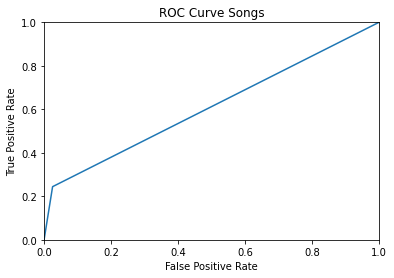

In [ ]:
# Plot ROC Curve for songs
fpr,tpr,thresholds = roc_curve (test_df['hit'],y_predicted_songs)

def plot_roc_curve(fpr,tpr): 
    plt.plot(fpr,tpr) 
    plt.axis([0,1,0,1]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.title('ROC Curve Songs')
    plt.show()    
  
plot_roc_curve (fpr,tpr) 